# Simulation Validation

## Setup

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp

import compare_westbrook as cmp

sns.set_style("darkgrid")

SCRIPT_DIR = os.path.abspath(os.path.dirname(""))

## Model

Westbrook gives a cell size approximation of $$\lambda \approx 29 \delta$$ where $\lambda$ is the cell size and $\delta$ is the induction length.

## Validation Criterion

Schultz and Shepherd used shock tube studies of induction time to validate a number of chemical mechanisms, and found that the mechanisms whose simulations most closely matched the measured induction time data

> simulated the experimental induction time data to within an average factor of 2.5 and 3.0, respectively.

Although their validation was for induction time rather than cell size, we are estimating cell size based on induction _length_, which corresponds to the induction time, and therefore we expect this factor to provide a reasonable validation criterion in the present work.

## Validation of Westbrook's Model

Westbrook states that the given approximation of cell size correlated "very well" with the experimental results of Manzhalei et al., shown below.

![manzhalei](manzhalei_1974.png)

For the purposes of this validation, we consider only the portion of the shown data directly collected by Manzhalei et al., i.e. not from a literature reference.

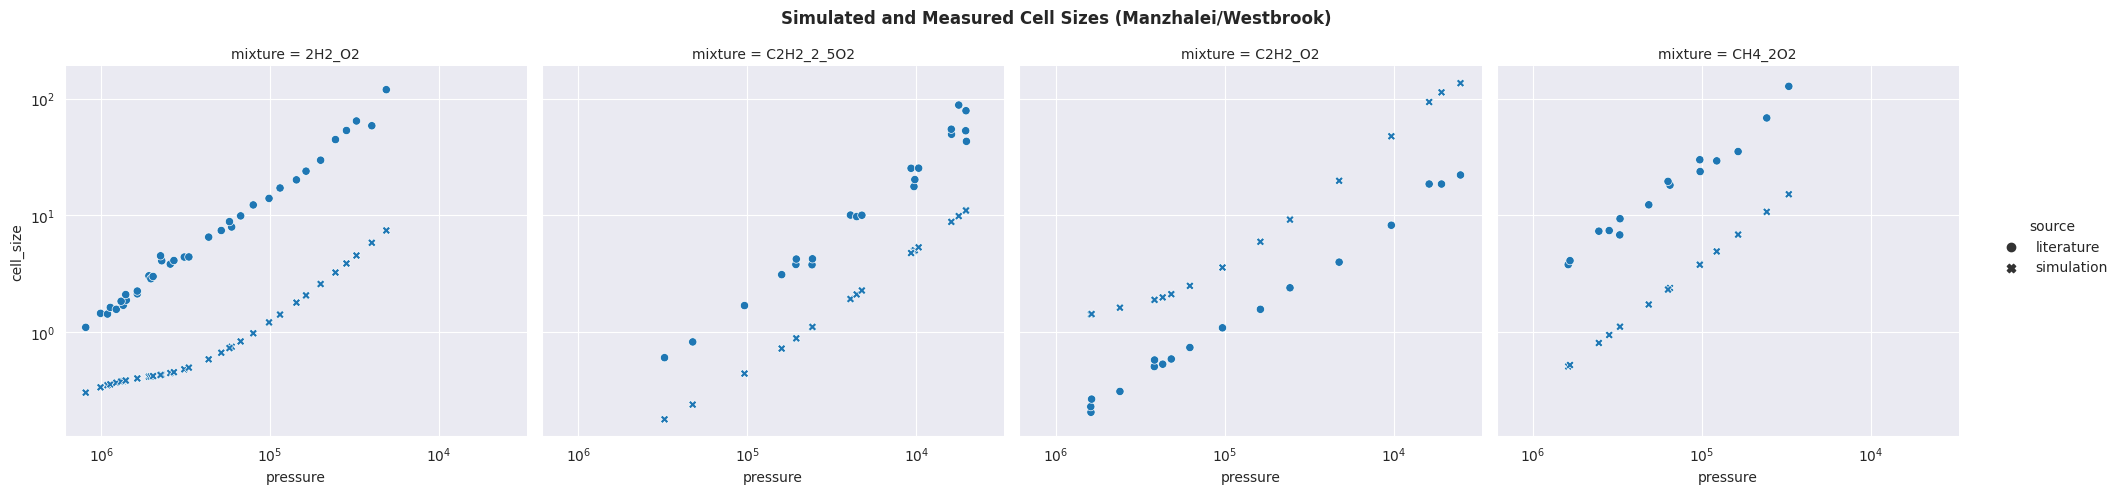

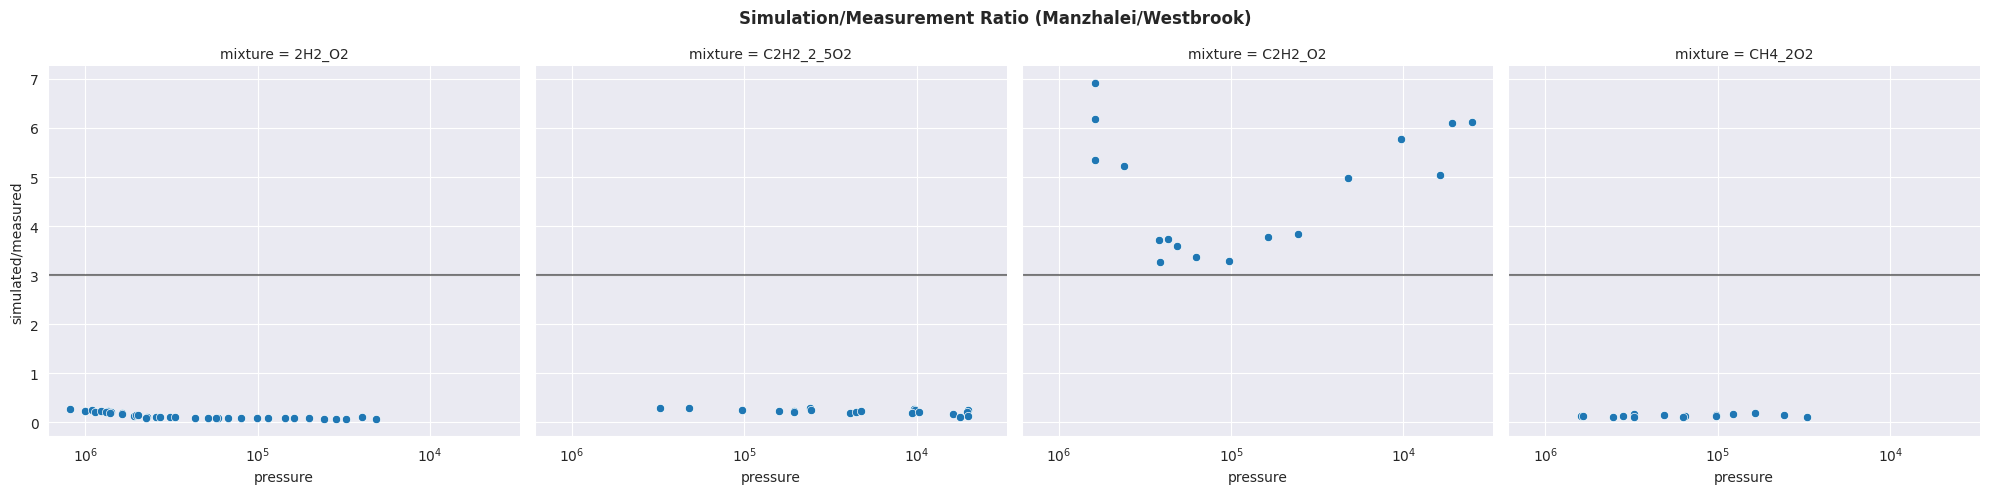

In [2]:
df_westbrook = cmp.load_westbrook_data()
df_deviation_westbrook = (
    df_westbrook[df_westbrook["source"] == "simulation"]
    .set_index(["mixture", "fuel", "oxidizer", "phi", "pressure"])["cell_size"]
    .div(
        df_westbrook[df_westbrook["source"] == "literature"]
        .set_index(["mixture", "fuel", "oxidizer", "phi", "pressure"])["cell_size"]
    )
).rename("simulated/measured").reset_index()

grid = sns.relplot(x="pressure", y="cell_size", style="source", col="mixture", data=df_westbrook, kind="scatter")
grid.set(xscale="log", yscale="log")
grid.axes[0][0].invert_xaxis()
grid.fig.suptitle("Simulated and Measured Cell Sizes (Manzhalei/Westbrook)", weight="bold")
grid.tight_layout()

grid = sns.relplot(x="pressure", y="simulated/measured", col="mixture", data=df_deviation_westbrook, kind="scatter")
grid.set(xscale="log", yscale="linear")
grid.axes[0][0].invert_xaxis()
for ax in grid.axes[0]:
    ax.axhline(3, c="k", alpha=0.5)
grid.fig.suptitle("Simulation/Measurement Ratio (Manzhalei/Westbrook)", weight="bold")
grid.tight_layout();

While the C2H2 + 2.5O2 mixture ($\phi = 2.5$) appears anomalous in that it has a higher ratio of simulated to measured values than the other conditions, the factor of 2.5-3 was represents the best case. Additionally, Schultz and Shepherd have noted that soot formation may occur in mixtures above $\phi \approx 2$, which may not be accounted for by a given chemical mechanism (p68). Therefore, this is not particularly concerning in the context of this validation study.

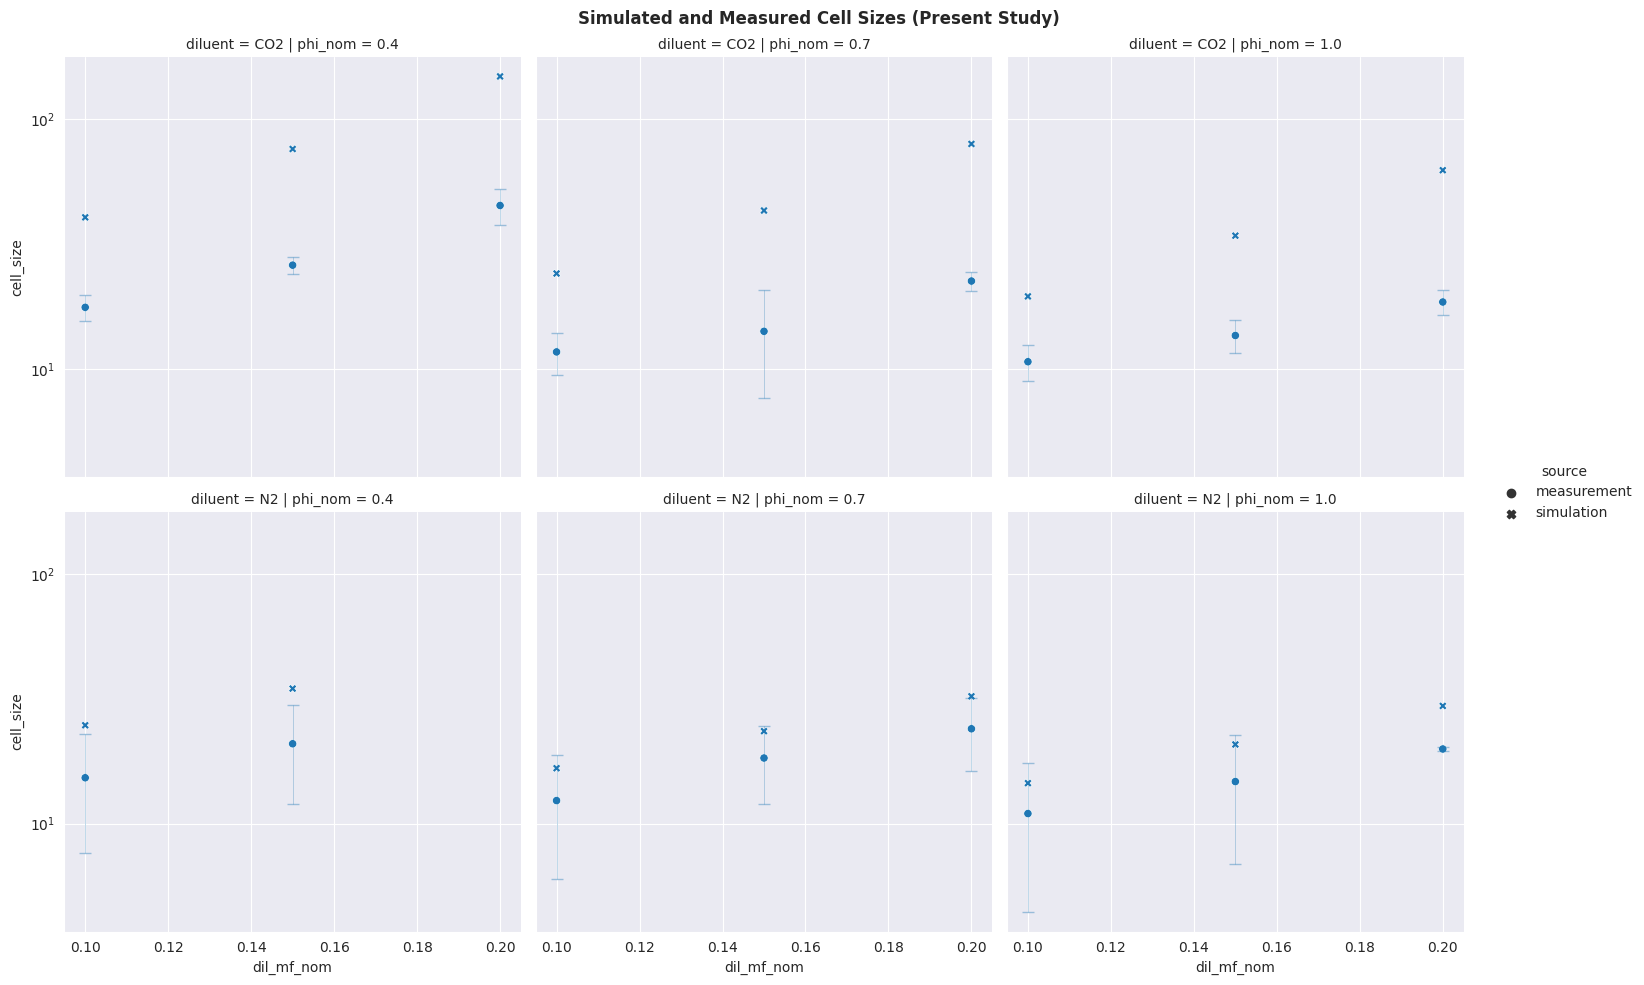

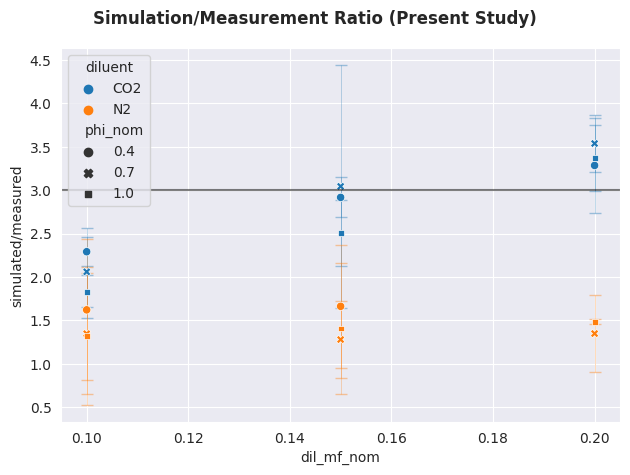

In [3]:
df_mine = cmp.load_my_data()

# group by diluent
co2_diluted_data = df_mine[(df_mine["diluent"] == "CO2")].set_index(
    ["fuel", "oxidizer", "phi_nom", "dil_mf_nom", "source"]
)[["cell_size", "uncertainty"]]
n2_diluted_data = df_mine[(df_mine["diluent"] == "N2")].set_index(
    ["fuel", "oxidizer", "phi_nom", "dil_mf_nom", "source"]
)[["cell_size", "uncertainty"]]

sim_measured_ratios = pd.DataFrame()
for phi_nom in (0.4, 0.7, 1.0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # group data by source
        co2_meas = co2_diluted_data[
            (co2_diluted_data.index.get_level_values("phi_nom") == phi_nom)
            & (co2_diluted_data.index.get_level_values("source") == "measurement")
        ]
        co2_sim = co2_diluted_data[
            (co2_diluted_data.index.get_level_values("phi_nom") == phi_nom)
            & (co2_diluted_data.index.get_level_values("source") == "simulation")
        ]
        n2_meas = n2_diluted_data[
            (n2_diluted_data.index.get_level_values("phi_nom") == phi_nom)
            & (n2_diluted_data.index.get_level_values("source") == "measurement")
        ]
        n2_sim = n2_diluted_data[
            (n2_diluted_data.index.get_level_values("phi_nom") == phi_nom)
            & (n2_diluted_data.index.get_level_values("source") == "simulation")
        ]

        # compare sim/meas with uncertainty
        co2_meas_values = unp.uarray(co2_meas["cell_size"].values, co2_meas["uncertainty"].values)
        n2_meas_values = unp.uarray(n2_meas["cell_size"].values, n2_meas["uncertainty"].values)
        co2_ratio = co2_sim["cell_size"].values / co2_meas_values
        n2_ratio = n2_sim["cell_size"].values / n2_meas_values
        
        sim_measured_ratios = pd.concat((
            sim_measured_ratios,
            pd.DataFrame(
                data={
                    "diluent": "CO2",
                    "simulated/measured": unp.nominal_values(co2_ratio),
                    "u_simulated/measured": unp.std_devs(co2_ratio),
                },
                index=co2_meas.index
            ),
            pd.DataFrame(
                data={
                    "diluent": "N2",
                    "simulated/measured": unp.nominal_values(n2_ratio),
                    "u_simulated/measured": unp.std_devs(n2_ratio),
                },
                index=n2_meas.index
            )
        ))
sim_measured_ratios.reset_index(inplace=True)

uncert_plot_args = dict(
    x="dil_mf_nom",
    ls="None",
    linewidth=0.5,
    zorder=1,
    capsize=4,
    alpha=0.4,
)

grid = sns.relplot(
    x="dil_mf_nom",
    y="cell_size",
    style="source",
    col="phi_nom",
    row="diluent",
    data=df_mine,
    kind="scatter",
)
for row, diluent in enumerate(("CO2", "N2")):
    for col, phi_nom in enumerate((0.4, 0.7, 1.0)):
        grid.axes[row][col].errorbar(
            y="cell_size",
            yerr="uncertainty",
            **uncert_plot_args,
            data=df_mine[(df_mine["diluent"] == diluent) & (df_mine["phi_nom"] == phi_nom)]
        )
# todo: add uncertainties
grid.set(xscale="linear", yscale="log")
grid.fig.suptitle("Simulated and Measured Cell Sizes (Present Study)", weight="bold")
grid.tight_layout()

fig = plt.figure()
sns.scatterplot(
    x="dil_mf_nom", 
    y="simulated/measured",
    style="phi_nom",
    hue="diluent",
    data=sim_measured_ratios,
    zorder=2,
)
fig.axes[0].errorbar(
    y="simulated/measured",
    yerr="u_simulated/measured",
    **uncert_plot_args,
    data=sim_measured_ratios[sim_measured_ratios["diluent"] == "CO2"],
)
fig.axes[0].errorbar(
    y="simulated/measured",
    yerr="u_simulated/measured",
    **uncert_plot_args,
    data=sim_measured_ratios[sim_measured_ratios["diluent"] == "N2"],
)
fig.axes[0].axhline(3, c="k", alpha=0.5)
fig.suptitle("Simulation/Measurement Ratio (Present Study)", weight="bold")
fig.tight_layout();

We can see from this plot that the simulated difference between N2 and CO2 dilution is far greater than the measured difference, which is almost non-existent.

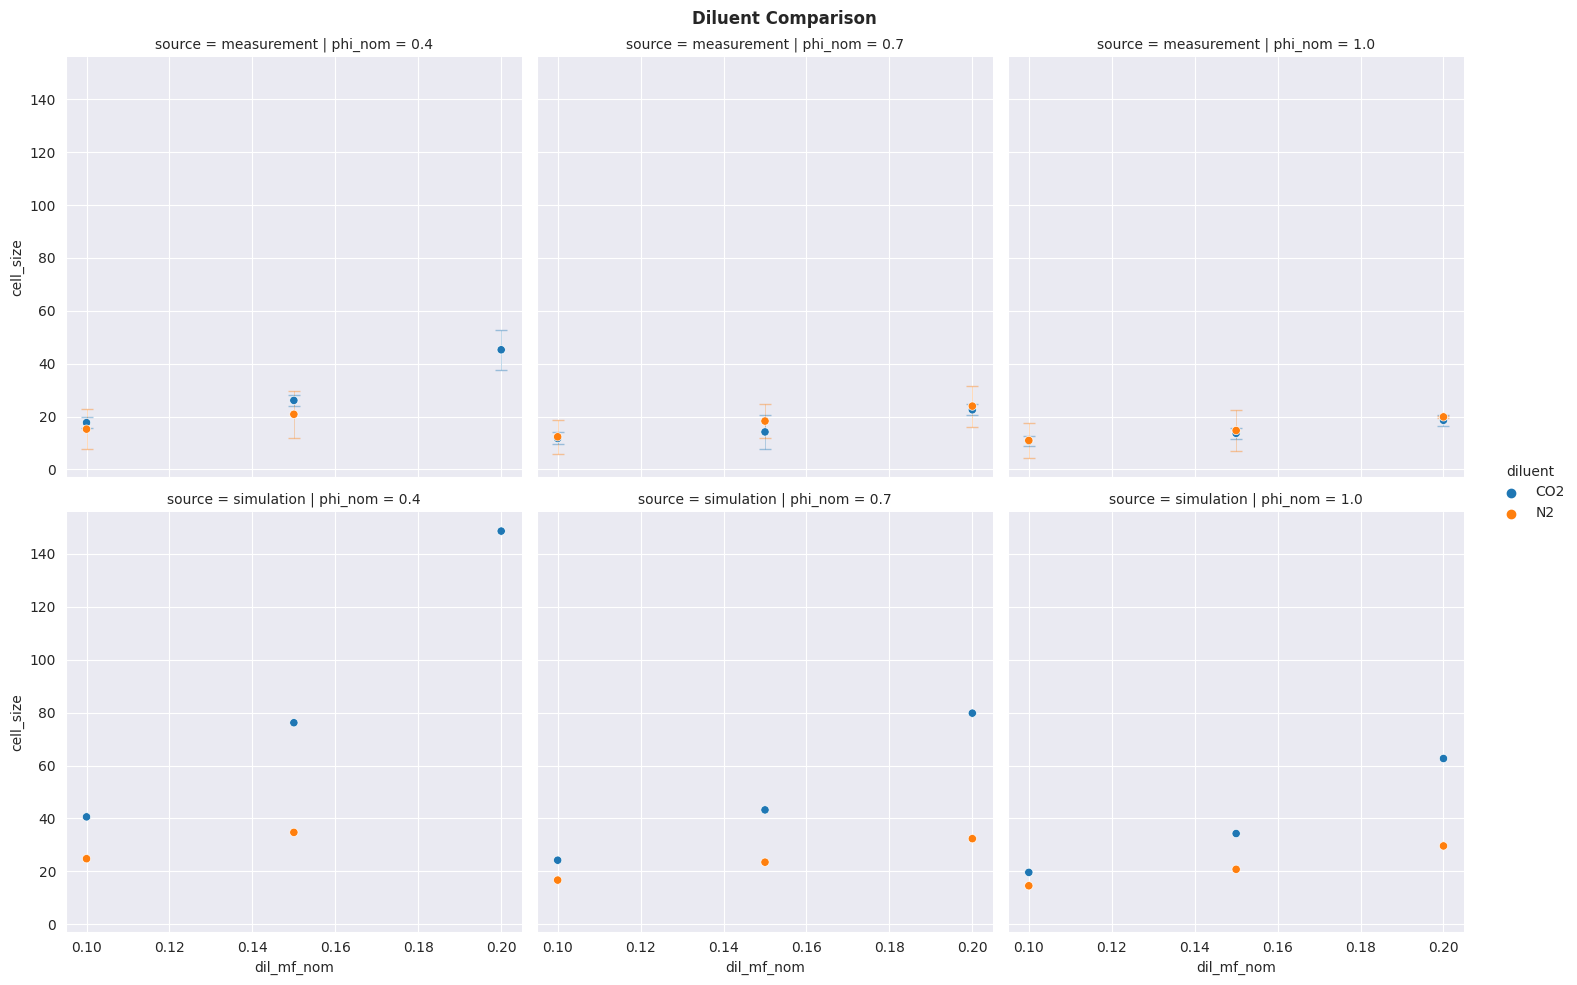

In [4]:
grid = sns.relplot(
    x="dil_mf_nom",
    y="cell_size",
    row="source",
    col="phi_nom",
    hue="diluent",
    data=df_mine,
    kind="scatter",
    zorder=2,
)
grid.fig.suptitle("Diluent Comparison", weight="bold")

measurements = df_mine[df_mine["source"] == "measurement"]
plot_args = dict(
    x="dil_mf_nom",
    y="cell_size",
    yerr="uncertainty",
    ls="None",
    linewidth=0.5,
    zorder=1,
    capsize=4,
    alpha=0.4,
)
grid.axes[0][0].errorbar(
    **plot_args,
    data=measurements[
        (measurements["phi_nom"] == 0.4)
        & (measurements["diluent"] == "CO2")]
)
grid.axes[0][0].errorbar(
    **plot_args,
    data=measurements[
        (measurements["phi_nom"] == 0.4)
        & (measurements["diluent"] == "N2")])
grid.axes[0][1].errorbar(
    **plot_args,
    data=measurements[
        (measurements["phi_nom"] == 0.7)
        & (measurements["diluent"] == "CO2")])
grid.axes[0][1].errorbar(
    **plot_args,
    data=measurements[
        (measurements["phi_nom"] == 0.7)
        & (measurements["diluent"] == "N2")])
grid.axes[0][2].errorbar(
    **plot_args,
    data=measurements[
        (measurements["phi_nom"] == 1.0)
        & (measurements["diluent"] == "CO2")
    ])
grid.axes[0][2].errorbar(
    **plot_args,
    data=measurements[
        (measurements["phi_nom"] == 1.0)
        & (measurements["diluent"] == "N2")
    ])

grid.tight_layout();

While normalizing the inter-diluent difference helps somewhat, the fact remains that we observe a greater difference in simulated cell size than we do in measured cell size as a result of the diluent species. I think that this is my biggest concern with this study: The measured values with varied diluents are more similar than the corresponding simulated values. However, given the degree of measurement uncertainty, I'm not sure we can say that that matters. The only remedy for the measurement uncertainty would be to collect more soot foil data.

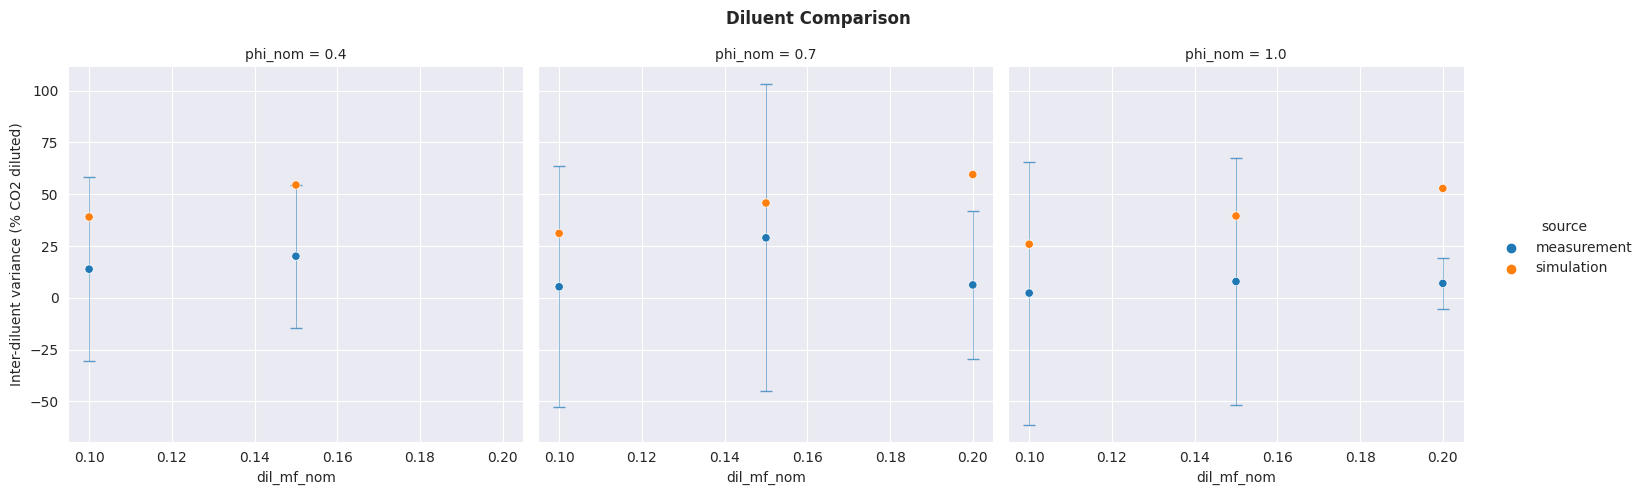

In [5]:
diluent_diffs = pd.DataFrame()

for axis_num, phi_nom in enumerate((0.4, 0.7, 1.0)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # match indices
        co2 = co2_diluted_data[co2_diluted_data.index.get_level_values("phi_nom") == phi_nom].filter(n2_diluted_data.index, axis=0)
        n2 = n2_diluted_data[n2_diluted_data.index.get_level_values("phi_nom") == phi_nom].filter(n2_diluted_data.index, axis=0)

        # compare diluents with uncertainty
        co2_meas = unp.uarray(co2["cell_size"].values, co2["uncertainty"].values)
        n2_meas = unp.uarray(n2["cell_size"].values, n2["uncertainty"].values)
        diffs = np.abs(co2_meas - n2_meas) / co2_meas * 100
        
        diluent_diffs = pd.concat((
            diluent_diffs,
            pd.DataFrame(
                data={
                    "difference": unp.nominal_values(diffs),
                    "u_difference": unp.std_devs(diffs),
                    "axis": axis_num,
                },
                index=co2.index
            )
        ))

grid = sns.relplot(
    x="dil_mf_nom",
    y="difference",
    hue="source",
    col="phi_nom",
    data=diluent_diffs,
    kind="scatter",
    zorder=2,
)
for axis_num, data in diluent_diffs.reset_index().groupby("axis"):
    grid.axes.flatten()[axis_num].errorbar(
        x="dil_mf_nom",
        y="difference",
        yerr="u_difference"
        , ls="None",
        linewidth=0.5,
        zorder=1,
        capsize=4,
        alpha=0.7,
        data=data,
    )
grid.axes.flatten()[0].set_ylabel("Inter-diluent variance (% CO2 diluted)")
grid.fig.suptitle("Diluent Comparison", weight="bold")
grid.tight_layout();